In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from matplotlib.animation import FuncAnimation

from numba import njit
from tqdm import tqdm

In [2]:
@njit
def lj_acc(rij):
    
    '''
    Get the 2D Lennard-Jones acceleration of two masses seperated by a distance rij.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • a : A numpy array 2 elements storing the `x` and `y` components of the acceleration.
    '''

    a=0                                # Computing the acceleration for each _pair_ of particles  
    rij = pbc_distance(rij)            #Using the Lenard-Jones potential to write formula for acceleration
    d = 1/np.sqrt(sum(rij**2))
    return 48*(d**14 - 0.5*d**8)*rij
    # <===== Q 3(b) Fill this in

@njit
def get_pe(step_pos,L):

    '''
    Get the 2D Lennard-Jones potential energy for a system of `N` masses.
    
    Parameters:
    -----------
    • pos : An `(N x 2)` numpy array of 2 elements storing the `x` and `y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • potential : The combined potential energy of the `N` masses.
    '''
    
    potential = 0
     
    for p in range(N-1):                                               
            for q in range(p+1,N):
                rpq = step_pos[p] - step_pos[q]                #Using the Lenard-Jones Potential 
                rij = pbc_distance(rpq)
                dist = 1/np.sqrt(sum(rij**2))
                potential = potential + 4*((dist)**12 - (dist)**6) 
    # <===== Q 3(b) Fill this in
    return potential

@njit
def get_ke(step_vel):
    
    '''
    Get the kinetic energy for a system of `N` masses.
    
    Parameters:
    -----------
    • vel : An `(N x 2)` numpy array of 2 elements storing the `v_x` and `v_y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • kinetic : The combined kinetic energy of the `N` masses.
    '''

    kinetic = 0
    for m in range(N):                                 #Calculating kinetik energy               
            
    # <===== Q 3(b) Fill this in
        vel = step_vel[m]
        velocity = np.sqrt(sum(vel**2))
        kinetic = kinetic + 0.5*velocity**2
    return kinetic 


@njit
def pbc_distance(rij):
    
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''
    
    if np.abs(rij[0]) > 0.5*L:
            rij[0] = rij[0] - L*(rij[0]/ np.abs(rij[0]))   
    if np.abs(rij[1]) > 0.5*L:
            rij[1] = rij[1] - L*(rij[1]/ np.abs(rij[1]))    
    # <===== Fill this in to compute the _true_ distance, taking into account
    # periodic boundary conditions
    
    return rij

@njit
def maxwell(v,T):
    '''
    Maxwell-Boltzmann distribution of velocities in two-dimensions
    
    Parameters:
    -----------
    • v    : Number or array of velocities
    • T    : Temperature at which the Maxwell-Boltzmann distribution is computed
    
    Returns:
    --------
    The function returns the probability density from the Maxwell-Boltzmann distribution:
    • p : If `v` is a numpy array, `p` is a numpy array. If `v` is a number, `p` is a number.
    '''

    p = (1./T)*v*np.exp(-0.5*v*v/T)
    
    return p

In [3]:
def init_pos(Lx, Ly, Nx, Ny):

    '''
    Assign the initial positions of the particles on a regular lattice
    
    Parameters:
    -----------
    • Lx   : x-length of the lattice
    • Ly   : y-length of the lattice
    • Nx   : An integer number of particles in the x-direction
    • Ny   : An integer number of particles in the y-direction
    
    Returns:
    --------
    The function returns one value:
    • ipos : A numpy array of (N x 2) elements storing the `x` and `y` coordinates of `N = Nx * Ny` particles.
    '''

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(Ny):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1                                    # Increment counter
    
    return ipos


def init_vel(N):

    '''
    Assign the initial velocities of the particles
    
    Parameters:
    -----------
    • N    : An integer number of particles
    
    Returns:
    --------
    The function returns one value:
    • ivel : A numpy array of (N x 2) elements storing the `x` and `y` velocity components of `N` particles.
    '''
    
    ivel = np.zeros((N,2), dtype=np.float32)         # Initialise the empty array for velocities 

    T = 2.5                                         # Initial "temperature" of the system
    T0 = 1                                           # Temperature scale of the problem

    v0 = np.sqrt(2*T/T0)                             # Initial speed of each particle

    for i in range(N):                               # Loop over each particle and 
        r = 2*np.pi*np.random.random()               # assign it a random direction
        ivel[i][0] = v0 * np.cos(r)                  # Set the x and y components of the velocity
        ivel[i][1] = v0 * np.sin(r)                  # while keeping the magnitude constant

    vcm = np.sum(ivel,axis=0)/N                      # Compute the centre of mass velocity
    ivel = ivel-vcm                                  # Subtract the COM velocity so the COM is stationary

    return ivel


In [4]:

@njit
def simulate(ipos, ivel, nu, T, tf=100, dt=0.01):

    '''
    Maxwell-Boltzmann distribution of velocities in two-dimensions
    
    Parameters:
    -----------
    • ipos : An (Nx2) array of initial positions of N particles in 2D
    • ivel : An (Nx2) array of initial velocities of N particles in 2D
    • tf   : (optional) Final time until which the simulation will run
    • dt   : (optional) Time-step between simulation steps
    
    Returns:
    --------
    The function four values
    • pos  : An array of `(n_steps x N x 2)` elements containing the (x,y) coordinates
             of each particle at each time-step. Eg: `pos[10]` gives a snapshot of the system
             at time-step 10
    • vel  : An array of `(n_steps x N x 2)` elements containing the (v_x,v_y) coordinates
             of each particle at each time-step. Eg: `vel[10]` gives the velocities of the system
             at time-step 10
    • KE   : An array of `n_steps` elements containing the total kinetic energy of the system at each step
    • PE   : An array of `n_steps` elements containing the total potential energy of the system at each step
    '''
    
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # Arrays to store the history of the particles'
    vel = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # positions and velocities

    KE = np.zeros(n_steps)                                   # Arrays to store the history of the particles'
    PE = np.zeros(n_steps)                                   # kinetic and potential energies
    P = np.zeros((n_steps,N-1))  
    pos[0] = ipos                                            # Setting initial positions to `ipos`
    vel[0] = ivel                                            # Setting initial velocities to `ivel`

    KE[0] = get_ke(vel[0])                                   # Computing initial kinetic and potential
    PE[0] = get_pe(pos[0], L=L)                              # energies
    

    for s in range(1,n_steps-1):  #tqdm(range(1,n_steps-1)):                         # Loop over steps. NOTE: tqdm doesn't work with Numba
        # <===== Q3(a) Fill this in: Increment positions to value at intermediate point
        pos[s] = pos[s - 1] + dt/2 * vel[s - 1] 
                
        

        # <===== Q3(a) Impose periodic boundary conditions for each dimension (x and y)
        for m in range(N):
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L

        net_a = np.zeros((N,2), dtype=np.float32)            # Empty array to store the net acceleration of each particle

        for p in range(N-1):                                 # Computing the acceleration for each _pair_ of particles              
            for q in range(p+1,N):
                
                acc = lj_acc(pos[s][p] - pos[s][q]) # acc = <==== Compute the acceleration between pairs of particles
                P[s][p] = pbc_distance(pos[s][p] - pos[s][q])[0]*acc[0] + pbc_distance(pos[s][p] - pos[s][q])[1]*acc[1]
                    
                
                net_a[p] += acc                              # Use the third-law to impart equal and opposite 
                net_a[q] -= acc                              # accelerations to each particle


        # <===== Q3(a) Update the velocity and final positions using the Verlet scheme
        vel[s] = vel[s - 1] + dt * net_a  
        pos[s] = pos[s] + dt/2 * vel[s]
                
        # <===== Q3(a) Re-impose periodic boundary conditions for each dimension (x and y)
        for m in range(N):
            if pos[s][m][0] >= L:
                pos[s][m][0] = pos[s][m][0] - L
            if pos[s][m][0] <= 0:
                pos[s][m][0] = pos[s][m][0] + L
            if pos[s][m][1] >= L:
                pos[s][m][1] = pos[s][m][1] - L
            if pos[s][m][1] <= 0:
                pos[s][m][1] = pos[s][m][1] + L

        for b in range(N):
            r = np.random.uniform(0,1)
            if r <= nu*dt:
                r1 = np.random.uniform(0,1)
                r2 = np.random.uniform(0,1)*2*np.pi
                vel[s][b][0] = np.sqrt(-2*T*np.log(r1))*np.cos(r2)
                vel[s][b][1] = np.sqrt(-2*T*np.log(r1))*np.sin(r2)                
                
        KE[s] = get_ke(vel[s])                               # Compute the kinetic and potential energies at 
        PE[s] = get_pe(pos[s], L=L)                          # the current step
        
    return pos, vel, KE, PE, P
        

In [5]:
##############################################
########### SIMULATION PARAMETERS ############
##############################################


Nx = 8                 # Number of particles per row initially along x
Ny = 8                  # Number of particles per row iniailly along y
N = Nx*Ny                # Total number of particles
rho = 0.5                # Density of the system
L = np.sqrt(N/rho)       # Length of the system

ipos = init_pos(Lx=L, Ly=L, Nx=Nx, Ny=Ny)  # Initial positions (square grid)
ivel = init_vel(N)                         # Initial velocities 


tf = 100
dt = 0.01
time = np.arange(0,int(tf/dt))*dt

In [6]:
%%time

##############################################
##### Run a single simulation forwards #######
##############################################

# For N=25, tf=100, and dt=0.01, this should take 
# about ~ 30 s to run without Numba, and ~ 1 s with Numba

pos,vel, KE, PE, P = simulate(ipos, ivel, 0.1, 2, tf=tf, dt=dt)

CPU times: total: 16.5 s
Wall time: 22.7 s


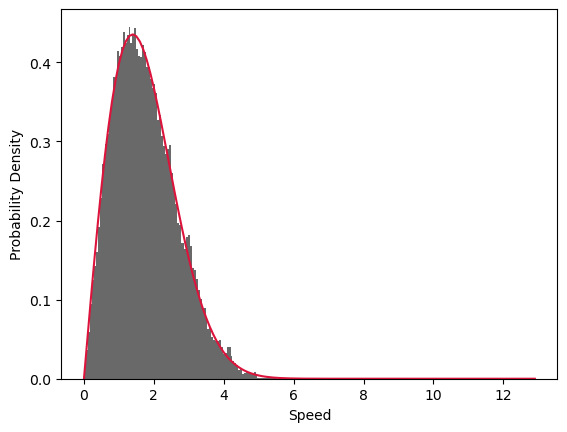

Temperature = 1.9397799769534725


In [7]:
speed = np.array([])
for i in range(2, 2000):
    for j in range(64):
        s = np.sqrt(vel[-i][j][0]**2 + vel[-i][j][1]**2)
        speed = np.append(speed, s)
plt.hist(speed, bins = 100, color = 'dimgrey',density = True)
o = np.arange(0, 13, 0.1)
plt.plot(o,maxwell(o, np.mean(KE[9000:])/64), color = 'crimson')
plt.ylabel('Probability Density')
plt.xlabel('Speed')
plt.show()

print('Temperature =', np.mean(KE[9000:]/N))

In [8]:
#Calculating the mean pressure using the formula. 
#P = simulate(ipos, ivel, 0.1, 2, tf=tf, dt=dt)[4]
press = sum(np.mean(P[8000:], axis = 0))
pressure = (press/(144*2)+1)*(64*2/144)
print('Mean pressure at T =  2 is =', pressure)

Mean pressure at T =  2 is = 1.4797006544882976


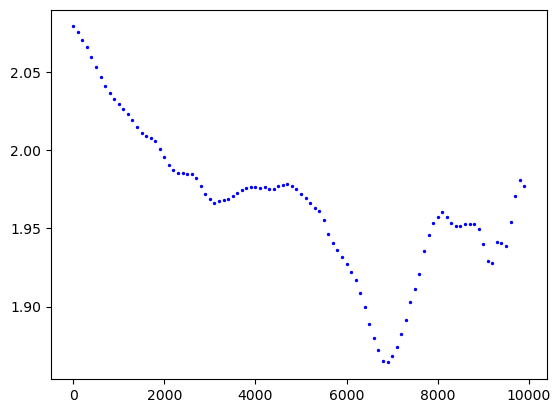

In [9]:
for f in range(0, 10000, 100):
    plt.scatter(f, np.mean(KE[f:]/N),s = 2, color = 'blue')

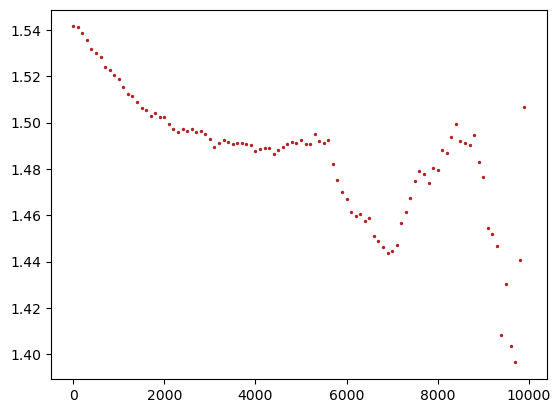

In [10]:
for f in range(0, 10000, 100):    
    press = sum(np.mean(P[f:], axis = 0))
    pressure = (press/(144*2)+1)*(64*2/144)
    plt.scatter(f, pressure, s = 2,color = 'firebrick')